# Sharded Cellpose Segmentation on human protein atlas images

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.classification import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example2.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    classification_f=CellFeaturizer,
    selection_f=LMDSelection,
)

modifying config
[27/01/2025 19:32:59] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/config.yml
[27/01/2025 19:32:59] Loading classes from default classes path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/segmentation/classes.csv
[27/01/2025 19:32:59] current run: 0


/Users/sophia/Documents/GitHub/scPortrait/src/scportrait/pipeline/project.py:161: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [3]:
from scportrait.data._datasets import dataset_2

dataset_2_path = dataset_2()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_2_path}/Ch1.tif", f"{dataset_2_path}/Ch2.tif", f"{dataset_2_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[27/01/2025 19:32:59] Overwrite is set to True. Existing input image was deleted.
[27/01/2025 19:32:59] saved input_image: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/input_image.ome.zarr


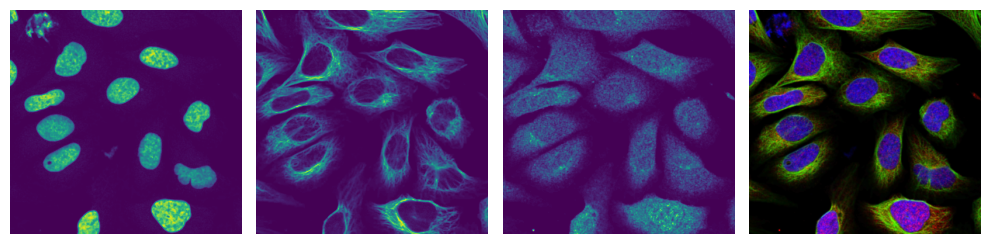

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time


def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[27/01/2025 19:32:59] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_tstf63xf for CytosolSegmentationCellpose
[27/01/2025 19:32:59] GPU Status for segmentation is True and will segment using the following device mps.
[27/01/2025 19:32:59] Segmenting nucleus using the following model: nuclei


/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

[27/01/2025 19:33:02] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[27/01/2025 19:33:03] Performing filtering to match Cytosol and Nucleus IDs.
[27/01/2025 19:33:03] Removed 4 nuclei and 3 cytosols due to filtering.
[27/01/2025 19:33:03] After filtering, 7 matching nuclei and cytosol masks remain.
[27/01/2025 19:33:03] Total time to perform nucleus and cytosol mask matching filtering: 0.38 seconds
[27/01/2025 19:33:03] Filtering status for this segmentation is set to True.
[27/01/2025 19:33:03] Filtering has been performed during segmentation. Nucleus and Cytosol IDs match. No additional steps are required.
[27/01/2025 19:33:03] Saved cell_id classes to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/segmentation/classes.csv.
[27/01/2025 19:33:03] === finished segmentation ===
[27/01/2025 19:33:03] save_zarr attribute not found
[27/01/2025 19:33:03] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_tstf63xf'>


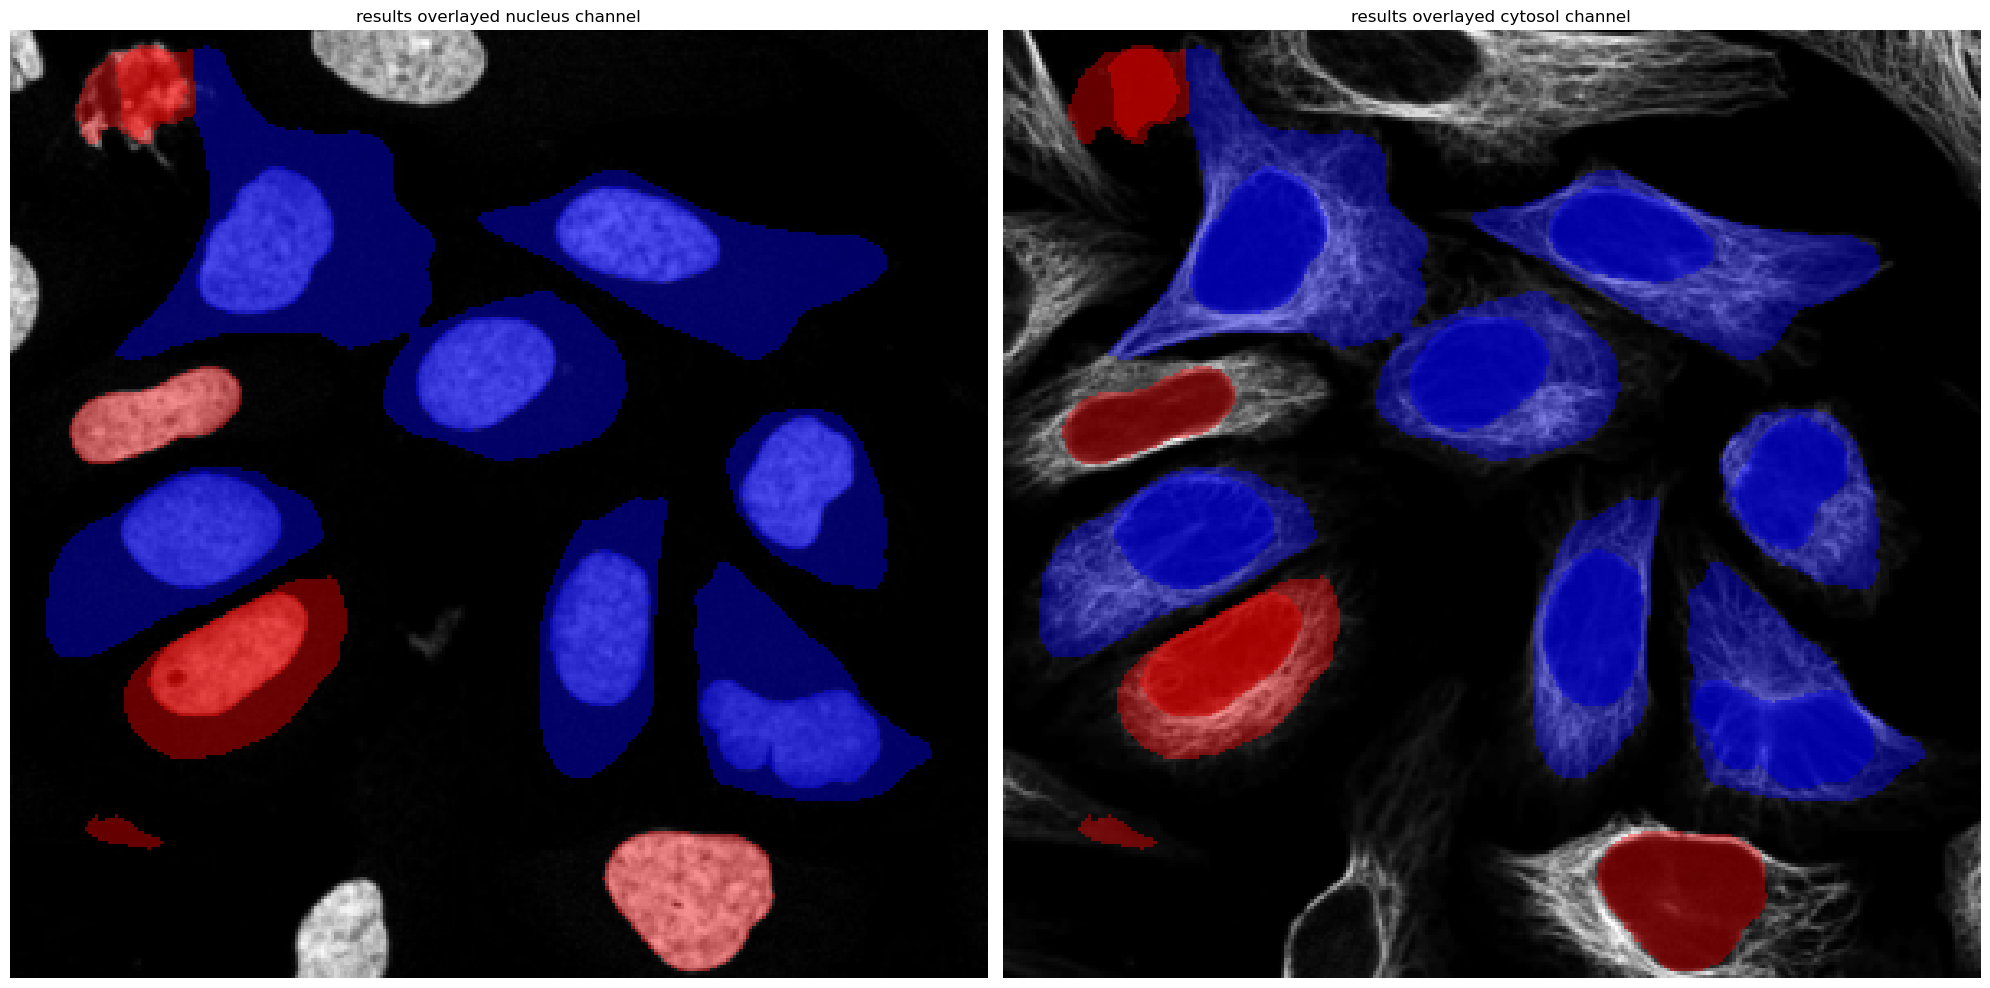

In [5]:
project.segment()

<HDF5 dataset "labels": shape (2, 290, 299), type "<u8">


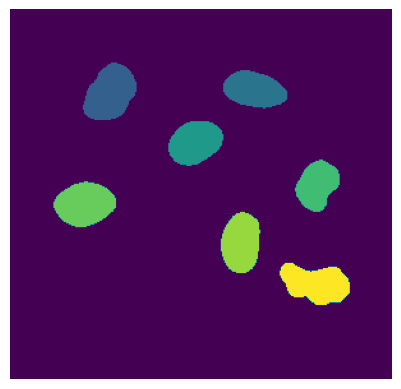

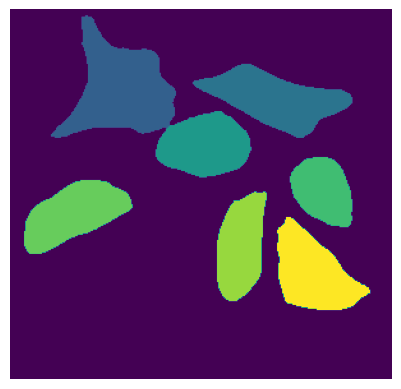

In [6]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [7]:
project.extract()

[27/01/2025 19:33:04] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_ehx86u6r for HDF5CellExtraction
[27/01/2025 19:33:04] Created new data directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data
[27/01/2025 19:33:04] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data
[27/01/2025 19:33:04] Using segmentation <HDF5 dataset "labels": shape (2, 290, 299), type "<u8">
[27/01/2025 19:33:04] Using channel information <HDF5 dataset "channels": shape (3, 290, 299), type "<u2">
[27/01/2025 19:33:04] Loaded 7 cellIds to extract.
[27/01/2025 19:33:04] After removing duplicates 7 cells remain.
[27/01/2025 19:33:04] Started cell coordinate calculation
[27/01/2025 19:33:05] Finished cell coordinate calculation
[27/01/2025 19:33:05] Cell coordinates saved to file /Users/sophia/Documents/GitHub/sc

Processing cell batches: 100%|██████████| 7/7 [00:00<00:00, 226.31it/s]


multiprocessing done.
[27/01/2025 19:33:05] Finished extraction in 0.10 seconds (72.52 cells / second)
[27/01/2025 19:33:05] Transferring results to final HDF5 data container.
[27/01/2025 19:33:05] number of cells too close to image edges to extract: 0
[27/01/2025 19:33:05] A total of 0 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/segmentation/removed_classes_too_close_to_edges.csv.
[27/01/2025 19:33:05] Transferring extracted single cells to .hdf5
[27/01/2025 19:33:05] single-cell index created.


Transferring single-cell images: 100%|██████████| 7/7 [00:00<00:00, 7352.90it/s]

[27/01/2025 19:33:05] single-cell data created
[27/01/2025 19:33:05] single-cell index labelled created.
[27/01/2025 19:33:05] channel information created.
[27/01/2025 19:33:05] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_ehx86u6r'>


(7, 5, 110, 110)


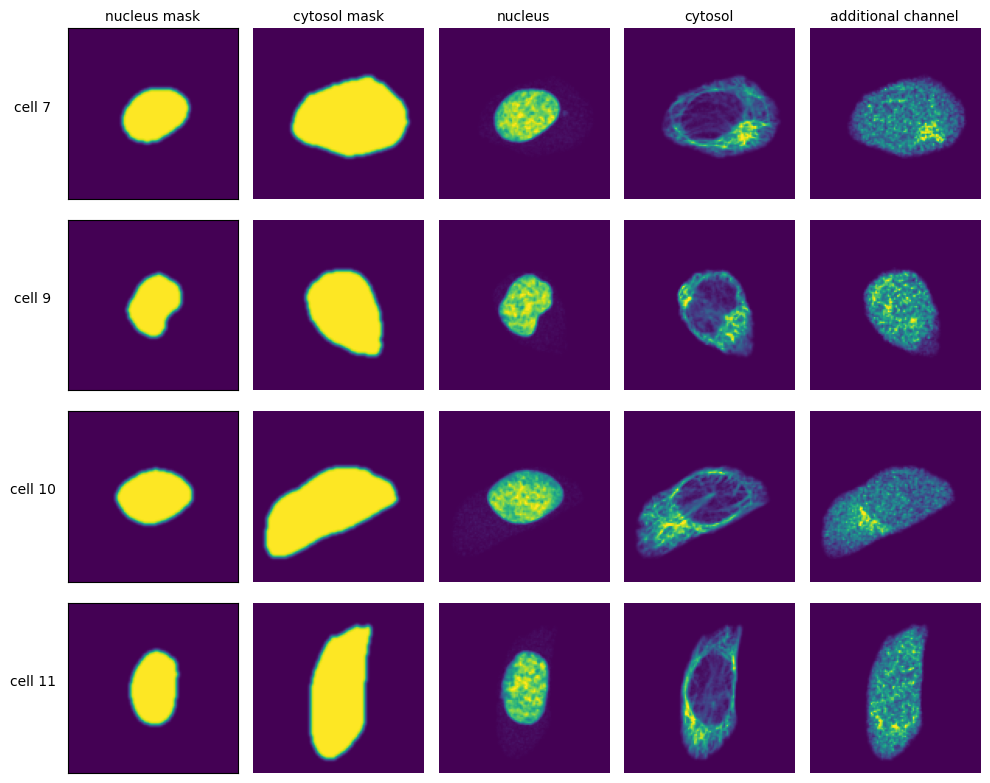

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

In [9]:
project.classify(accessory = [(), (), ()])

[27/01/2025 19:33:06] Started classification
[27/01/2025 19:33:06] starting with run 0
[27/01/2025 19:33:06] channel_classification: 4
[27/01/2025 19:33:06] batch_size: 900
[27/01/2025 19:33:06] dataloader_worker_number: 0
[27/01/2025 19:33:06] inference_device: cpu
[27/01/2025 19:33:06] screen_label: Ch3_Featurization
[27/01/2025 19:33:06] 0 different accessory datasets specified
[27/01/2025 19:33:06] loading /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_2/project/extraction/data/single_cells.h5
[27/01/2025 19:33:06] Total: 7
0: 7

[27/01/2025 19:33:06] start processing 1 batches
[27/01/2025 19:33:06] finished processing


/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/torch/masked/maskedtensor/creation.py:19: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  return MaskedTensor(data, mask, requires_grad)
/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:102: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  return MaskedTensor(result_data, result_mask)
/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:247: UserWarning: The PyTorch API of MaskedTensors is in prototype s

In [11]:
# load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch3_Featurization/calculated_features.csv")
results

,Unnamed: 0,nucleus_area,cytosol_area,mean,median,quant75,quant25,summed_intensity_nucleus_area,summed_intensity_cytosol_area,summed_intensity_nucleus_area_normalized,summed_intensity_cytosol_area_normalized,label,cell_id
0,0,2014.0,4259.0,0.089448,0.0,0.091553,0.0,692.52630,1082.3153,0.343856,0.254124,0,13
1,1,2043.0,6255.0,0.123432,0.0,0.222168,0.0,844.50037,1493.5212,0.413363,0.238772,0,4
2,2,1768.0,3839.0,0.089199,0.0,0.021355,0.0,724.08716,1079.3033,0.409552,0.281142,0,7
3,3,1746.0,4319.0,0.108607,0.0,0.089417,0.0,789.82630,1314.1406,0.452363,0.304270,0,5
4,4,1586.0,2841.0,0.074152,0.0,0.000000,0.0,743.41144,897.2368,0.468734,0.315817,0,9
5,5,1972.0,4059.0,0.085502,0.0,0.036766,0.0,655.31670,1034.5684,0.332311,0.254883,0,10
6,6,1820.0,3528.0,0.092088,0.0,0.000152,0.0,821.54956,1114.2695,0.451401,0.315836,0,11
